# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This project presents an analysis of a **marketing campaign conducted by a Portuguese bank**, aimed at promoting term deposit subscriptions. The data was collected between May 2008 and November 2010 and is sourced from UCI Machine Learning Repository. 

The campaign involved direct phone calls to the bank’s existing customers and captures a wide range of variables across several categories:

**Client-related features:** Age, marital status, education, housing loan, personal loan, etc.

**Campaign interaction details:** Type of communication, contact month and weekday, duration of the call, and the result of the current campaign.

**Economic indicators:** Employment variation rate, consumer price index, consumer confidence index, etc.

**Target variable:** Whether the client subscribed to a term deposit (yes or no).


The dataset consists of **41,188 records**, with an overall term deposit acceptance rate of approximately **11%**.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report)
import time


In [1219]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [1220]:
data = df
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [1221]:
data['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [1222]:
data.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Exploring the dataset

In [1225]:
df.rename(columns= {'y':'deposit'}, inplace=True)

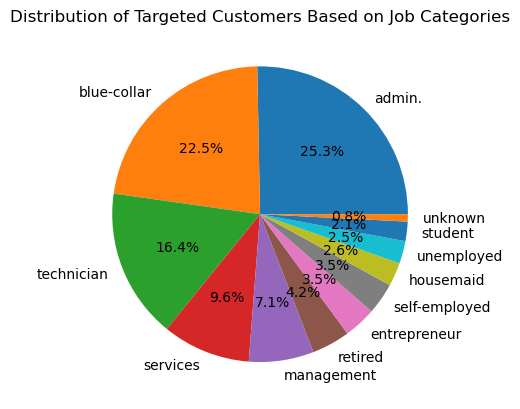

In [1226]:
# Pie Chart to visualize how are the target customers distributed based on their job category
job_counts = data['job'].value_counts()
plt.pie(job_counts,labels=job_counts.index, autopct='%1.1f%%')
plt.xticks(rotation = 45)
plt.title('Distribution of Targeted Customers Based on Job Categories')

plt.show()

The pie chart indicates that the **main target customers of the campaign are administrators, blue-collar workers, and technicians** while students, self-employed individuals, and unemployed customers represent the smallest segments.

In [1228]:
grouped_by_marital = data.groupby('marital')['deposit'].value_counts().unstack()
grouped_by_marital

deposit,no,yes
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


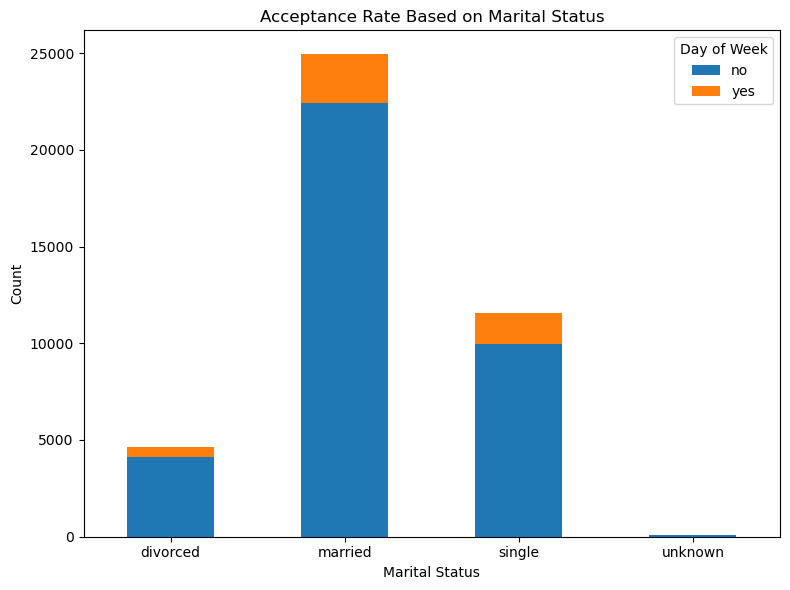

In [1229]:
# Stacked Bar Plot to visialize how the marital status of the custome affects their decision
grouped_by_marital.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title("Acceptance Rate Based on Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

**Married customers form the primary target group** for the term deposit campaign, showing a **solid acceptance rate**, while **divorced** individuals show a significantly **lower acceptance rate**.

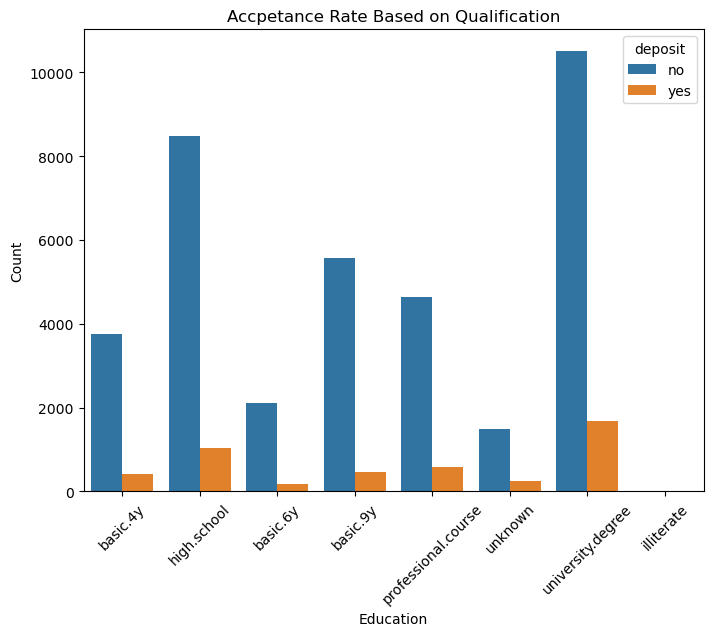

In [1231]:
# Bar plot to visualize the influence of education in making decision
plt.figure(figsize=(8, 6))
sns.countplot(data = data, x='education', hue ='deposit')
plt.xticks(rotation = 45)
plt.title('Accpetance Rate Based on Qualification')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()

The analysis also shows that education level plays a significant role in acceptance rates. Individuals with a university degree are more likely to accept term deposits, followed by those with a high school education.

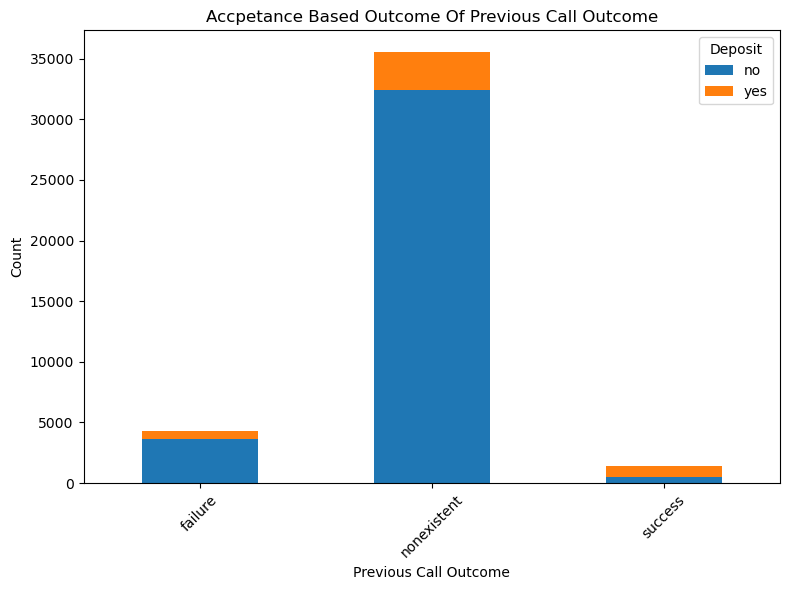

In [1233]:
# Stacked bar plot to visualise the previous call outcome on decision making
grouped = data.groupby('poutcome')['deposit'].value_counts().unstack()

grouped.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title("Accpetance Based Outcome Of Previous Call Outcome")
plt.xticks(rotation = 45)
plt.xlabel("Previous Call Outcome")
plt.ylabel("Count")
plt.legend(title='Deposit')
plt.tight_layout()
plt.show()

The outcome of the previous campaign appears to significantly influence the decision regarding term deposit acceptance. The graph shows that customers who had a successful previous campaign are far less likely to deny the term deposit offer. Conversely, if the previous campaign resulted in failure, the likelihood of acceptance becomes very low.

In [1235]:
grouped = data.groupby('month')['deposit'].value_counts().unstack()
grouped

deposit,no,yes
month,,
apr,2093,539
aug,5523,655
dec,93,89
jul,6525,649
jun,4759,559
mar,270,276
may,12883,886
nov,3685,416
oct,403,315


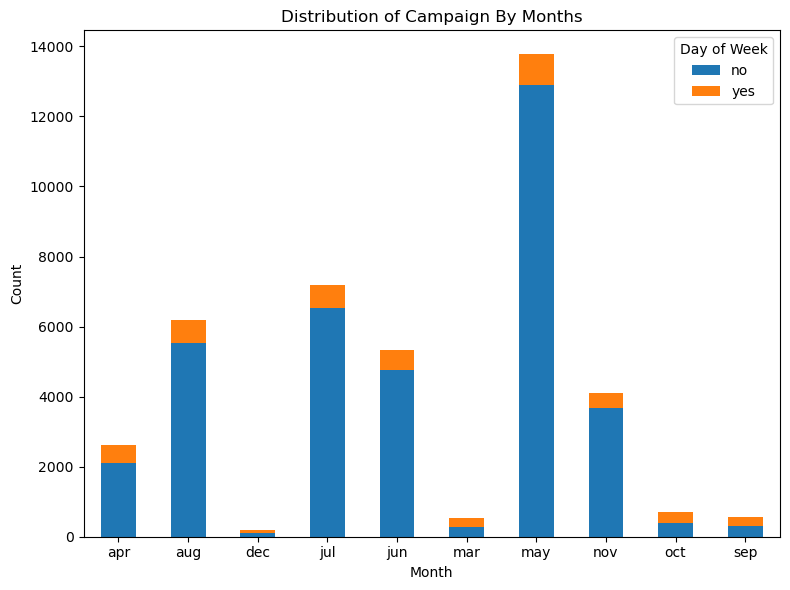

In [1236]:
# Stacked Bar Plot to visualize the distribution of campaign across months
grouped.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title("Distribution of Campaign By Months")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

The bar plot highlights a clear seasonal trend in campaign activity, with a **significant surge in customer targeting from May to August**. Activity **drops off sharply between September and April**, and appears to be nearly inactive in January and February, suggesting a possible campaign hold during those months.

In [1238]:
df.drop(columns=['emp.var.rate','cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' ],axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,yes


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [1240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [1241]:
df['euribor3m'].value_counts()

euribor3m
4.857    2868
4.962    2613
4.963    2487
4.961    1902
4.856    1210
         ... 
3.853       1
3.901       1
0.969       1
0.956       1
3.669       1
Name: count, Length: 316, dtype: int64

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [1243]:
# Label Encoding the categorical variables
label_encoder = LabelEncoder()

In [1244]:
df['job'] = label_encoder.fit_transform(df['job'])
df['marital'] = label_encoder.fit_transform(df['marital'])
df['education'] = label_encoder.fit_transform(df['education'])
df['contact'] = label_encoder.fit_transform(df['contact'])
df['month'] = label_encoder.fit_transform(df['month'])
df['day_of_week'] = label_encoder.fit_transform(df['day_of_week'])
df['poutcome'] = label_encoder.fit_transform(df['poutcome'])

In [1245]:
df['default'] = label_encoder.fit_transform(df['default'])
df['housing'] = label_encoder.fit_transform(df['housing'])
df['loan'] = label_encoder.fit_transform(df['loan'])
df['deposit'] = label_encoder.fit_transform(df['deposit'])

In [1246]:
# Standardizing numerical columns - For gaussian distribution

In [1247]:
scaler = StandardScaler()

In [1248]:
df['duration'] = scaler.fit_transform(df[['duration']])
df['age'] = scaler.fit_transform(df[['age']])
df['previous'] = scaler.fit_transform(df[['previous']])
df['campaign'] = scaler.fit_transform(df[['campaign']])


In [1249]:
#pdays colum has outliers 999, when the client was not previously contacted. This could be an outlier and influence when scaling. So using Robust scaler
rbscaler = RobustScaler()
df['pdays'] = rbscaler.fit_transform(df[['pdays']])

In [1250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  float64
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  duration        41188 non-null  float64
 11  campaign        41188 non-null  float64
 12  pdays           41188 non-null  float64
 13  previous        41188 non-null  float64
 14  poutcome        41188 non-null  int64  
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [1252]:
X = df.drop(columns='deposit') 
y = df['deposit'] 

In [1253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Using Dummy Classifier from sklearn.dummy. This is a rule based classifier that serves as a baseline comparison for sophisticated classifiers 

In [1256]:
# Building a Baseline Classifier
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [1257]:
y_pred_baseline = baseline_model.predict(X_test)

In [1258]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Baseline Model Accuracy: 0.8874


We see the base line model gives an accuracy of 88%.

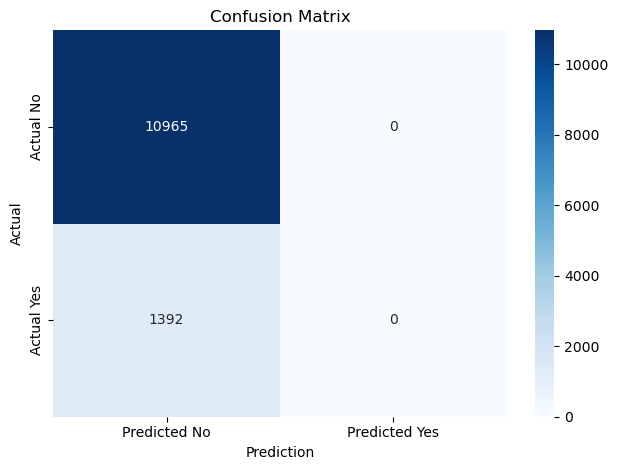

In [1260]:
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [1261]:
# Metrics of Baseline Classifier
results = []
results.append({
    'Model': 'Baseline Classifier',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'F1 Score': f1_score(y_test, y_pred_baseline, average='weighted'),
    'Precision': precision_score(y_test, y_pred_baseline, average='weighted'),
    'Recall': recall_score(y_test, y_pred_baseline, average='weighted')
})
baseline_results = pd.DataFrame(results)
baseline_results

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,F1 Score,Precision,Recall
0,Baseline Classifier,0.887351,0.834389,0.787392,0.887351


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [1263]:
Models = ['Logistic Regression', 'Decision Tree Classifier', 'KNearestNeighbor', 'SVM']
training_times = []
training_accuracies = []
test_accuracies= []

In [1264]:
# Building a Logistic Regression Model
start_time = time.time()
Logistic_Regression_Model = LogisticRegression(solver='liblinear',max_iter=500)
Logistic_Regression_Model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

In [1265]:
training_times.append(training_time)

### Problem 9: Score the Model

What is the accuracy of your model?

In [1267]:
lr_y_pred = Logistic_Regression_Model.predict(X_test)

In [1268]:
accuracy = accuracy_score(y_test, lr_y_pred)
training_accuracies.append(Logistic_Regression_Model.score(X_train, y_train))
test_accuracies.append(accuracy)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9098


The Logictic Regression Model gives an accuracy of 90%

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [1271]:
# Building a Decision Tree Classifier
start_time = time.time()
Decision_Tree_Classifier_Model = DecisionTreeClassifier()
Decision_Tree_Classifier_Model.fit(X_train, y_train)
end_time = time.time()

In [1272]:
training_time = end_time - start_time
training_times.append(training_time)
print(f"Training time for Decision Tree Classifier: {training_time:.4f} seconds")

Training time for Decision Tree Classifier: 0.1395 seconds


In [1273]:
dt_y_pred = Decision_Tree_Classifier_Model.predict(X_test)
accuracy = accuracy_score(y_test, dt_y_pred)
training_accuracies.append(Decision_Tree_Classifier_Model.score(X_train, y_train))
test_accuracies.append(accuracy)
print(f"Decision Tree Classifier Accuracy: {accuracy:.4f}")

Decision Tree Classifier Accuracy: 0.8892


In [1274]:
# Building a K Nearest Neighbor Classifier
start_time = time.time()
KNeighborsClassifier_Model = KNeighborsClassifier()
KNeighborsClassifier_Model.fit(X_train, y_train)
end_time = time.time()

In [1275]:
training_time = end_time - start_time
training_times.append(training_time)
print(f"Training time for KNN: {training_time:.4f} seconds")

Training time for KNN: 0.0035 seconds


In [1276]:
knn_y_pred = KNeighborsClassifier_Model.predict(X_test)
training_accuracies.append(KNeighborsClassifier_Model.score(X_train, y_train))
accuracy = accuracy_score(y_test, knn_y_pred)
test_accuracies.append(accuracy)
print(f"KNN Accuracy: {accuracy:.4f}")

KNN Accuracy: 0.9012


In [1277]:
# Building a SVM Classifier
start_time = time.time()
SVM_Model = SVC()
SVM_Model.fit(X_train, y_train)
end_time = time.time()

In [1278]:
training_time = end_time - start_time
training_times.append(training_time)
print(f"Training time for SVM: {training_time:.4f} seconds")

Training time for SVM: 3.2650 seconds


In [1279]:
svm_y_pred = SVM_Model.predict(X_test)
training_accuracies.append(SVM_Model.score(X_train, y_train))
accuracy = accuracy_score(y_test, svm_y_pred)
test_accuracies.append(accuracy)
print(f"SVM Accuracy: {accuracy:.4f}")

SVM Accuracy: 0.8982


In [1280]:
data = {
    'Model': Models,
    'Train Time': training_times,
    'Train Accuracy': training_accuracies,
    'Test Accuracy': test_accuracies
}


In [1281]:
training_times

[0.06986331939697266,
 0.1394810676574707,
 0.0035440921783447266,
 3.2650110721588135]

In [1282]:
comparison = pd.DataFrame(data)

In [1283]:
comparison.sort_values(by='Train Time')

,Model,Train Time,Train Accuracy,Test Accuracy
2,KNearestNeighbor,0.003544,0.926052,0.901190
0,Logistic Regression,0.069863,0.909091,0.909768
1,Decision Tree Classifier,0.139481,1.000000,0.889213
3,SVM,3.265011,0.897229,0.898195


In [1284]:
models = {
    'KNN': KNeighborsClassifier_Model,
    'Logistic Regression':Logistic_Regression_Model ,
    'Decision Tree Classifier': Decision_Tree_Classifier_Model,
    'SVM': SVM_Model
}

In [1285]:
# Evaluating various metrics of classifiers
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    })
df_results = pd.DataFrame(results)

In [1286]:
df_results

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.901190,0.891788,0.888146,0.901190
1,Logistic Regression,0.909768,0.898403,0.897528,0.909768
2,Decision Tree Classifier,0.889213,0.889846,0.890503,0.889213
3,SVM,0.898195,0.872968,0.878786,0.898195


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [1288]:
# Hyperparameter tuning for KNN classifier

In [1289]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier_Model , param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [1290]:
grid_search.best_params_

{'algorithm': 'auto',
 'metric': 'euclidean',
 'n_neighbors': 10,
 'weights': 'distance'}

In [1291]:
best_knn_model = grid_search.best_estimator_
best_knn_model.score(X_test, y_test)

0.903293679695719

In [1292]:
best_models_test_accuracies=[]
best_models_test_accuracies.append(best_knn_model.score(X_test, y_test))

In [1293]:
# Hyperparameter Tuning for Logistic Regression

In [1294]:
param_grid = {
    'C': [0.01, 0.1, 1, 10], 
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2']  
}
random_search = RandomizedSearchCV(
    estimator=Logistic_Regression_Model,
    param_distributions=param_grid,
    n_iter=6, 
    cv=3,      
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=500,
                                                solver='liblinear'),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   scoring='accuracy', verbose=1)

In [1295]:
random_search.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

In [1296]:
LR_best_model = random_search.best_estimator_
LR_best_model.score(X_test, y_test)

0.9115481103827789

In [1297]:
best_models_test_accuracies.append(LR_best_model.score(X_test, y_test))

In [1298]:
# Hyperparameter tuning for decision classifier

In [1299]:
param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50]
}
grid_search = GridSearchCV(estimator=Decision_Tree_Classifier_Model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [1300]:
best_dt_classifier_model = grid_search.best_estimator_
best_dt_classifier_model.score(X_test, y_test)

0.915270696771061

In [1301]:
best_models_test_accuracies.append(best_dt_classifier_model.score(X_test, y_test))
best_models_test_accuracies.append(accuracy_score(y_test, svm_y_pred))

Hypertuning SVM took hours and so I skip that for time being and considering the model build witout hyperparameter tuning.

In [1303]:
data = {
    'Model': ['Logistic Regression', 'Decision Tree Classifier', 'KNearestNeighbor', 'SVM'],
    'Test Accuracy Before Hyperparameter Tuning': test_accuracies,
    'Test Accuracy After Hyperparameter Tuning': best_models_test_accuracies
}

In [1304]:
Classifier_Comparison = pd.DataFrame(data)

In [1305]:
Classifier_Comparison

,Model,Test Accuracy Before Hyperparameter Tuning,Test Accuracy After Hyperparameter Tuning
0,Logistic Regression,0.909768,0.903294
1,Decision Tree Classifier,0.889213,0.911548
2,KNearestNeighbor,0.901190,0.915271
3,SVM,0.898195,0.898195


The table presents a comparison of the Accuracy metric for each model, evaluated before and after hyperparameter tuning. The results indicate a notable improvement in accuracy for both the Decision Tree Classifier and K-Nearest Neighbors (KNN) following tuning. In contrast, the Logistic Regression model exhibits minimal change, suggesting that its default parameters were already near-optimal or less sensitive to tuning in this context.


In [1307]:
best_models = {
    'KNN': best_knn_model,
    'Logistic Regression':LR_best_model ,
    'Decision Tree Classifier': best_dt_classifier_model,
    'SVM': SVM_Model
}

In [1308]:
# Evaluating various metrics of classifiers
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    })
best_models_results = pd.DataFrame(results)

### Metrics Pre-Hyperparameter Tuning

In [1310]:
df_results

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.901190,0.891788,0.888146,0.901190
1,Logistic Regression,0.909768,0.898403,0.897528,0.909768
2,Decision Tree Classifier,0.889213,0.889846,0.890503,0.889213
3,SVM,0.898195,0.872968,0.878786,0.898195


### Metrics Post Hyperparameter Tuning

In [1312]:
best_models_results

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.903294,0.891480,0.888927,0.903294
1,Logistic Regression,0.911548,0.901306,0.900207,0.911548
2,Decision Tree Classifier,0.915271,0.913957,0.912846,0.915271
3,SVM,0.898195,0.872968,0.878786,0.898195


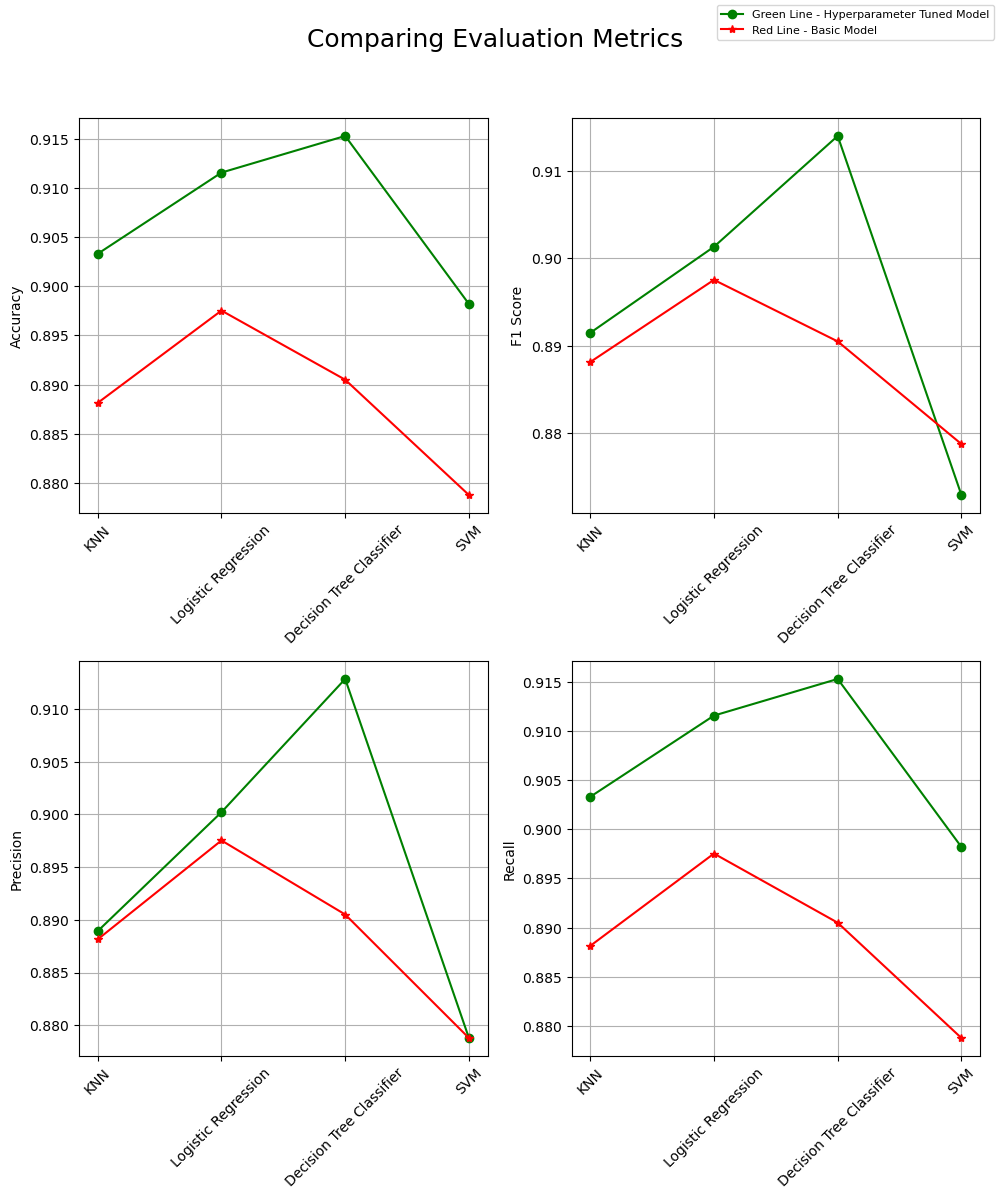

In [1313]:
fig, axes = plt.subplots(2,2, figsize=(10, 12))
fig.suptitle("Comparing Evaluation Metrics", fontsize=18)

#Accuracy Plot
best_model_line, = axes[0,0].plot(best_models_results['Model'], best_models_results['Accuracy'],marker='o', linestyle='-', color='g')
basic_model_line, = axes[0,0].plot(df_results['Model'], df_results['Precision'],marker='*', linestyle='-', color='r')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True)


# F1-score Plot plot
best_model_line, = axes[0,1].plot(best_models_results['Model'], best_models_results['F1 Score'],marker='o', linestyle='-', color='g')
basic_model_line, = axes[0,1].plot(df_results['Model'], df_results['Precision'],marker='*', linestyle='-', color='r')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True)

# Precision Plot
best_model_line, = axes[1,0].plot(best_models_results['Model'], best_models_results['Precision'],marker='o', linestyle='-', color='g')
basic_model_line, = axes[1,0].plot(df_results['Model'], df_results['Precision'],marker='*', linestyle='-', color='r')
axes[1,0].set_ylabel('Precision')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True)

# Recall Plot
best_model_line, = axes[1,1].plot(best_models_results['Model'], best_models_results['Recall'],marker='o', linestyle='-', color='g')
basic_model_line, = axes[1,1].plot(df_results['Model'], df_results['Precision'],marker='*', linestyle='-', color='r')
axes[1,1].set_ylabel('Recall')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True)

fig.legend([best_model_line, basic_model_line], ['Green Line - Hyperparameter Tuned Model', 'Red Line - Basic Model'], loc='upper right', ncol=1, fontsize=8)

# Add a common legend with custom contents
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with title
plt.show()

The graphs compare Accuracy, F1 Score, Precision, and Recall between the best models (post-hyperparameter tuning) and basic models (pre-tuning). The results show a clear and substantial improvement across all metrics after hyperparameter tuning, demonstrating the effectiveness of optimizing model parameters to enhance performance. The improvement highlights how fine-tuning can make models more accurate and reliable.

### Choosing the Evaluation Metric

The dataset is **highly imbalanced**, with only ~4,500 positive cases out of 41,188 records, making **Accuracy an unreliable metric**.  

**In campaign scenarios, both false positives (contacting uninterested users) and false negatives (missing interested customers) are costly, so balance is key.**

**F1-Score is the suitable metric which brings in balance.**


In [1317]:
F1_Score_comparison = pd.DataFrame({'Models': ['KNN','Logistic Regression','Decision Tree Classifier','SVM'], 'Pre-Tuned Model F1-Score':df_results['F1 Score'], 'Hypertuned Models F1-Score':best_models_results['F1 Score']})

### F1 Score Comparison

In [1319]:
F1_Score_comparison

,Models,Pre-Tuned Model F1-Score,Hypertuned Models F1-Score
0,KNN,0.891788,0.891480
1,Logistic Regression,0.898403,0.901306
2,Decision Tree Classifier,0.889846,0.913957
3,SVM,0.872968,0.872968


### Decision Tree Confusion Matrix

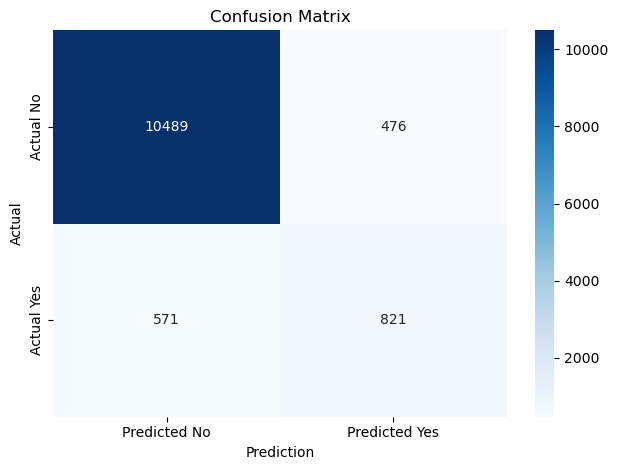

In [1321]:
decision_tree_prediction = pd.DataFrame(best_dt_classifier_model.predict(X_test))
cm = confusion_matrix(y_test, decision_tree_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Conclusion

Among all evaluation metrics, the **F1 Score is the most appropriate** for this imbalanced classification problem, as it effectively balances Precision and Recall. The **Decision Tree Classifier achieves the highest F1 Score** among all the models evaluated. Based on this evidence, it can be concluded that the Decision Tree is the most suitable model for this campaign scenario.